# **Day 10: Optimizing Models**
---

### **Description**
This notebook shows how to implement and use the topics that we've been discussing in optimizing models.

<br>

### **Structure**
**Part 1**: [Hyperparameter Tuning](#p1)
>
> **Part 1.1**: [Random Search](#p1.1)
>
> **Part 1.2**: [Bayesian Optimization](#p1.2)

**Part 2**: [Early Stopping and Regularization](#p2)

**Part 3**: [Challenge Problem](#p3)

<br>

### **Learning Objectives**

1. Recognize and implement various hyperparameter tuning techniques, including random search and Bayesian optimization, to optimize the performance of neural network models using pytorch and hyperopt.

1. Recognize the concepts and applications of early stopping and regularization techniques (L2 and dropout) in preventing overfitting and improving the generalization of machine learning models.

<br>

### **Resources**
* [Model Optimization Cheat Sheet](https://docs.google.com/document/d/1O3_U4EAp1QsFSq894d0B6mZ-CiAvFhU7s0vpn9iyuSw/edit)


<br>

**Run the cell below to load all necessary functions and libraries. NOTE: You may have to restart the notebook after running the first cell of installations.**

In [ ]:
!pip --quiet install scikit-learn scikit-optimize
!pip --quiet install torchview torch graphviz
!pip --quiet install fastai
!pip --quiet install hyperopt
!conda install -q python-graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 56.6 MB/s eta 0:00:00
/bin/bash: line 1: conda: command not found


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score



import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, load_breast_cancer

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

from fastai.vision.all import *
from fastai.tabular.all import *

from torchview import draw_graph

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from hyperopt import fmin, tpe, rand, hp, Trials, STATUS_OK



def binary_accuracy(y_pred, y_true):
    # Output 0 if y_pred <= 0.5 and 1 if y_pred is > 0.5
    y_pred = (y_pred > 0.5).float()
    # Returns accuracy
    return (y_pred == y_true).float().mean()



# Generate some synthetic data
X, y = make_classification(n_samples = 1000, n_features = 20, n_informative = 10, class_sep=0.01, random_state=28)


# Split the data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)


# Convert the numpy arrays to PyTorch tensors with float32 data type
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_valid_torch = torch.tensor(X_valid, dtype=torch.float32)
y_valid_torch = torch.tensor(y_valid, dtype=torch.float32).unsqueeze(1)

# Create dataset object
train_ds = list(zip(X_train_torch, y_train_torch))
valid_ds = list(zip(X_valid_torch, y_valid_torch))

# Define the DataLoaders
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=True)

dls = DataLoaders(train_dl, valid_dl)

<a name="p1"></a>

---
## **Part 1: Hyperparameter Tuning**
---

In this section, we will explore how to implement random search, grid search, and Bayesian optimization for hyperparameter tuning with neural networks. This will build upon what we've seen already for KNN. Some key points about these approaches:

<br>

1. **Random Search**

This randomly samples hyperparameter combinations from predefined ranges. It's straightforward to implement and can efficiently explore the hyperparameter space without exhaustively searching all possible combinations.

It is commonly used in deep learning due to its simplicity and ability to handle large search spaces efficiently. This is particularly important since deep learning models often have many hyperparameters.


<br>

2. **Grid Search**

This exhaustively searches all possible combinations of hyperparameters within predefined ranges. While it's easy to understand and implement, it can be computationally expensive, especially for high-dimensional hyperparameter spaces.

This is not commonly used in general due to its inefficiency. However, it's valuable to understand a basic way to approach a more structure search than a random one. And in some cases where there are not too many hyperparameters or too wide a range to search, it may actually be useful.


<br>

3. **Bayesian Optimization**

This uses probabilistic models to guide the search for optimal hyperparameters. It's more computationally efficient than grid search and can adaptively explore promising regions of the search space, leading to faster convergence.

It is increasingly popular in deep learning due to its efficiency and ability to handle complex search spaces. It's particularly well-suited for deep learning models with many hyperparameters, as it can efficiently explore the space and find optimal configurations.

<a name="p1.1"></a>

---
### **Part 1.1: Random Search**
---

In this section, we will see how to run a random search over hyperparameter values.

<br>

**NOTE**: We are using relatively conventional hyperparameter values to search within as follows:
* Using `10**np.random.uniform(-4, -2)` generates learning rates in the range $[0.0001, 0.01]$.
* This range is chosen because it covers small to moderately large learning rates, which are commonly effective for training neural networks.
* The exponential scale ensures that we can effectively explore a wide range of learning rates in our random search.

#### **Problem #1.1.1**



In [ ]:
from hyperopt import fmin, tpe, hp, Trials

# Define the objective function to minimize (Hyperopt minimizes the loss, so we negate accuracy)
def objective(params):

    model = nn.Sequential(
      nn.Linear(20, params['neurons']),
      nn.ReLU(),
      nn.Linear(params['neurons'], 1),
      nn.Sigmoid()
    )

    loss_func = nn.BCELoss()
    learn = Learner(dls, model, loss_func=loss_func, metrics=binary_accuracy)
    learn.fit(10, lr=params['learning_rate'])

    valid_loss, valid_accuracy = learn.validate()

    return {'loss': -valid_accuracy, 'status': STATUS_OK}



# Define the search space
space = {
    'neurons': hp.randint('neurons', 1, 5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-2), np.log(1e-1))
}

# Perform optimization
best = fmin(fn=objective, space=space, algo=rand.suggest, max_evals=5)
print(best)

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.688256,0.683197,0.565000,00:00
1,0.642820,0.585721,0.660000,00:00
2,0.585420,0.498616,0.775000,00:00
3,0.528325,0.416931,0.840000,00:00
4,0.480091,0.394770,0.830000,00:00
5,0.440140,0.347899,0.865000,00:00
6,0.411371,0.409107,0.825000,00:00
7,0.383578,0.368210,0.845000,00:00
8,0.359255,0.378187,0.810000,00:00
9,0.341626,0.354899,0.855000,00:00


 20%|██        | 1/5 [00:01<00:07,  2.00s/trial, best loss: -0.8550000190734863]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.746498,0.713554,0.505000,00:00
1,0.722812,0.696283,0.500000,00:00
2,0.704805,0.686492,0.525000,00:00
3,0.691482,0.676198,0.555000,00:00
4,0.678274,0.660222,0.515000,00:00
5,0.664528,0.648403,0.535000,00:00
6,0.651240,0.632171,0.535000,00:00
7,0.638578,0.619908,0.535000,00:00
8,0.626937,0.610873,0.540000,00:00
9,0.616012,0.597376,0.575000,00:00


 40%|████      | 2/5 [00:03<00:05,  1.77s/trial, best loss: -0.8550000190734863]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.680024,0.659320,0.595000,00:00
1,0.625773,0.564874,0.695000,00:00
2,0.570967,0.496586,0.710000,00:00
3,0.526689,0.436838,0.770000,00:00
4,0.485172,0.414779,0.795000,00:00
5,0.451353,0.389946,0.800000,00:00
6,0.421883,0.382311,0.795000,00:00
7,0.401670,0.408827,0.790000,00:00
8,0.382210,0.375131,0.815000,00:00
9,0.365814,0.385060,0.805000,00:00


 60%|██████    | 3/5 [00:05<00:03,  1.84s/trial, best loss: -0.8550000190734863]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.702784,0.687977,0.530000,00:00
1,0.695258,0.679558,0.520000,00:00
2,0.690516,0.677315,0.555000,00:00
3,0.685753,0.664778,0.565000,00:00
4,0.678060,0.648469,0.610000,00:00
5,0.669654,0.644221,0.600000,00:00
6,0.660577,0.652176,0.565000,00:00
7,0.651128,0.644482,0.580000,00:00
8,0.643785,0.640933,0.575000,00:00
9,0.636577,0.637111,0.605000,00:00


 80%|████████  | 4/5 [00:08<00:02,  2.32s/trial, best loss: -0.8550000190734863]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.690918,0.684902,0.555000,00:00
1,0.676995,0.677542,0.560000,00:00
2,0.656738,0.639268,0.595000,00:00
3,0.629101,0.580089,0.675000,00:00
4,0.596840,0.522430,0.725000,00:00
5,0.564185,0.480318,0.755000,00:00
6,0.532866,0.449637,0.775000,00:00
7,0.501906,0.419296,0.800000,00:00
8,0.478795,0.401931,0.795000,00:00
9,0.457458,0.395961,0.790000,00:00


100%|██████████| 5/5 [00:12<00:00,  2.50s/trial, best loss: -0.8550000190734863]
{'learning_rate': 0.07236335564069396, 'neurons': 4}


#### **Problem #1.1.2**

Although the setup can look complicated, we can rerun this search for a different range of hyperparameter values with about half of the code. For example, the code below searches the following range:
* Neurons: 10 to 50
* Learning rate: 1e-3 to 1e-1
* Maximum number of evaluations: 10

In [ ]:
# Define the search space
space = {
    'neurons': hp.randint('neurons', 10, 50),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-3), np.log(1e-1))
}

# Perform optimization
best = fmin(fn=objective, space=space, algo=rand.suggest, max_evals=10)
print(best)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.693883,0.683634,0.540000,00:00
1,0.688833,0.681195,0.555000,00:00
2,0.684493,0.679801,0.585000,00:00
3,0.679396,0.678103,0.580000,00:00
4,0.674972,0.675747,0.570000,00:00
5,0.670249,0.672545,0.580000,00:00
6,0.664506,0.667882,0.595000,00:00
7,0.658978,0.662467,0.610000,00:00
8,0.652032,0.656573,0.645000,00:00
9,0.644537,0.650411,0.650000,00:00


 10%|█         | 1/10 [00:01<00:17,  1.93s/trial, best loss: -0.6499999761581421]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.658485,0.554074,0.710000,00:00
1,0.540795,0.386684,0.800000,00:00
2,0.438560,0.346961,0.825000,00:00
3,0.361112,0.267374,0.885000,00:00
4,0.300754,0.264689,0.890000,00:00
5,0.253554,0.260076,0.890000,00:00
6,0.213138,0.270665,0.875000,00:00
7,0.184341,0.312598,0.880000,00:00
8,0.161056,0.311362,0.890000,00:00
9,0.141303,0.277671,0.905000,00:00


 20%|██        | 2/10 [00:03<00:14,  1.87s/trial, best loss: -0.9049999713897705]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.679658,0.676006,0.550000,00:00
1,0.651201,0.647413,0.630000,00:00
2,0.620686,0.600941,0.670000,00:00
3,0.583757,0.538710,0.760000,00:00
4,0.539943,0.472132,0.820000,00:00
5,0.492524,0.416001,0.845000,00:00
6,0.444934,0.368685,0.870000,00:00
7,0.401300,0.340437,0.880000,00:00
8,0.361123,0.316313,0.890000,00:00
9,0.326756,0.294106,0.895000,00:00


 30%|███       | 3/10 [00:05<00:13,  1.91s/trial, best loss: -0.9049999713897705]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.672745,0.673070,0.540000,00:00
1,0.624306,0.590371,0.710000,00:00
2,0.565917,0.484050,0.800000,00:00
3,0.503115,0.404406,0.830000,00:00
4,0.440734,0.331954,0.860000,00:00
5,0.384428,0.309353,0.860000,00:00
6,0.335004,0.286770,0.885000,00:00
7,0.293549,0.283560,0.895000,00:00
8,0.257411,0.273627,0.910000,00:00
9,0.229203,0.273030,0.900000,00:00


 40%|████      | 4/10 [00:07<00:10,  1.69s/trial, best loss: -0.9049999713897705]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.685048,0.692289,0.540000,00:00
1,0.679409,0.687300,0.520000,00:00
2,0.673955,0.681311,0.535000,00:00
3,0.666676,0.673103,0.565000,00:00
4,0.659805,0.665126,0.575000,00:00
5,0.651590,0.653529,0.590000,00:00
6,0.642197,0.641398,0.610000,00:00
7,0.632158,0.629555,0.620000,00:00
8,0.621830,0.614903,0.630000,00:00
9,0.610479,0.601134,0.655000,00:00


 50%|█████     | 5/10 [00:09<00:09,  1.92s/trial, best loss: -0.9049999713897705]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.707839,0.681403,0.560000,00:00
1,0.700932,0.679028,0.530000,00:00
2,0.694709,0.676039,0.565000,00:00
3,0.688721,0.673719,0.580000,00:00
4,0.682970,0.670152,0.600000,00:00
5,0.676566,0.666196,0.610000,00:00
6,0.670624,0.661264,0.600000,00:00
7,0.664447,0.656222,0.615000,00:00
8,0.657277,0.649677,0.630000,00:00
9,0.650386,0.643847,0.620000,00:00


 60%|██████    | 6/10 [00:11<00:08,  2.08s/trial, best loss: -0.9049999713897705]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.676488,0.666270,0.570000,00:00
1,0.618042,0.566314,0.720000,00:00
2,0.550187,0.466503,0.795000,00:00
3,0.481643,0.383951,0.855000,00:00
4,0.414955,0.339575,0.860000,00:00
5,0.361009,0.307026,0.865000,00:00
6,0.311549,0.282228,0.900000,00:00
7,0.270240,0.271126,0.880000,00:00
8,0.236820,0.280018,0.890000,00:00
9,0.207985,0.275610,0.905000,00:00


 70%|███████   | 7/10 [00:13<00:05,  1.94s/trial, best loss: -0.9049999713897705]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.658669,0.608870,0.705000,00:00
1,0.548274,0.405520,0.825000,00:00
2,0.446782,0.334621,0.850000,00:00
3,0.378367,0.313037,0.845000,00:00
4,0.320036,0.283292,0.885000,00:00
5,0.269737,0.253808,0.915000,00:00
6,0.230192,0.303263,0.880000,00:00
7,0.198301,0.262615,0.910000,00:00
8,0.172039,0.273772,0.910000,00:00
9,0.149374,0.350423,0.880000,00:00


 80%|████████  | 8/10 [00:15<00:03,  1.94s/trial, best loss: -0.9049999713897705]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.618804,0.556457,0.700000,00:00
1,0.514461,0.419823,0.780000,00:00
2,0.424424,0.315287,0.835000,00:00
3,0.354750,0.301078,0.860000,00:00
4,0.309598,0.312650,0.850000,00:00
5,0.278005,0.289945,0.855000,00:00
6,0.249292,0.353765,0.855000,00:00
7,0.226477,0.278387,0.880000,00:00
8,0.206744,0.285505,0.865000,00:00
9,0.189555,0.335696,0.870000,00:00


 90%|█████████ | 9/10 [00:17<00:01,  1.85s/trial, best loss: -0.9049999713897705]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.701110,0.699693,0.500000,00:00
1,0.697318,0.697381,0.490000,00:00
2,0.692589,0.695352,0.505000,00:00
3,0.688191,0.692727,0.525000,00:00
4,0.683595,0.689875,0.540000,00:00
5,0.678726,0.686592,0.550000,00:00
6,0.673515,0.683885,0.580000,00:00
7,0.667880,0.679395,0.585000,00:00
8,0.662736,0.675047,0.590000,00:00
9,0.656840,0.669182,0.595000,00:00


100%|██████████| 10/10 [00:19<00:00,  1.91s/trial, best loss: -0.9049999713897705]
{'learning_rate': 0.04050003009871443, 'neurons': 33}


#### **Problem #1.1.3**

Now, modify the code above to perform a random search of 15 different values within these hyperparameter ranges:
* Number of neurons: 1 to 150
* Learning rate: 1e-5 to 1e-3
* Maximum number of evaluations: 10

In [ ]:
# COMPLETE THIS CODE

##### **Solution**

In [ ]:
# Define the search space
space = {
    'neurons': hp.randint('neurons', 1, 150),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-3))
}

# Perform optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=rand.suggest, max_evals=10, trials=trials)
print(best)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.690014,0.710296,0.485000,00:00
1,0.688128,0.707434,0.480000,00:00
2,0.685672,0.705238,0.475000,00:00
3,0.683076,0.702966,0.465000,00:00
4,0.681062,0.701162,0.480000,00:00
5,0.679308,0.699434,0.475000,00:00
6,0.677457,0.697876,0.485000,00:00
7,0.675265,0.696008,0.485000,00:00
8,0.673274,0.694106,0.480000,00:00
9,0.671296,0.692184,0.490000,00:00


 10%|█         | 1/10 [00:01<00:16,  1.80s/trial, best loss: -0.49000000953674316]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.701722,0.718548,0.470000,00:00
1,0.699355,0.717402,0.465000,00:00
2,0.698468,0.716497,0.455000,00:00
3,0.696705,0.715386,0.445000,00:00
4,0.695285,0.714478,0.455000,00:00
5,0.693703,0.713569,0.450000,00:00
6,0.692715,0.712917,0.455000,00:00
7,0.691200,0.712039,0.450000,00:00
8,0.690071,0.711311,0.445000,00:00
9,0.688461,0.710391,0.435000,00:00


 20%|██        | 2/10 [00:03<00:16,  2.03s/trial, best loss: -0.49000000953674316]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.698679,0.700369,0.490000,00:00
1,0.698714,0.700292,0.490000,00:00
2,0.698506,0.700222,0.485000,00:00
3,0.698406,0.700153,0.485000,00:00
4,0.698222,0.700081,0.485000,00:00
5,0.697904,0.700028,0.480000,00:00
6,0.697648,0.699949,0.485000,00:00
7,0.697163,0.699875,0.480000,00:00
8,0.696865,0.699823,0.480000,00:00
9,0.696746,0.699771,0.480000,00:00


 30%|███       | 3/10 [00:05<00:12,  1.84s/trial, best loss: -0.49000000953674316]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.702389,0.690964,0.485000,00:00
1,0.701315,0.690476,0.480000,00:00
2,0.700509,0.690048,0.480000,00:00
3,0.699822,0.689606,0.485000,00:00
4,0.699632,0.689133,0.485000,00:00
5,0.699533,0.688729,0.490000,00:00
6,0.699034,0.688298,0.495000,00:00
7,0.698386,0.687846,0.495000,00:00
8,0.698032,0.687447,0.505000,00:00
9,0.697415,0.687036,0.525000,00:00


 40%|████      | 4/10 [00:07<00:09,  1.67s/trial, best loss: -0.5249999761581421] 

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.708832,0.695358,0.505000,00:00
1,0.698899,0.690733,0.500000,00:00
2,0.690144,0.687623,0.555000,00:00
3,0.682778,0.682722,0.565000,00:00
4,0.675076,0.677996,0.595000,00:00
5,0.667138,0.671243,0.610000,00:00
6,0.659284,0.665217,0.615000,00:00
7,0.650750,0.658953,0.635000,00:00
8,0.642546,0.651943,0.640000,00:00
9,0.633695,0.644293,0.670000,00:00


 50%|█████     | 5/10 [00:08<00:07,  1.52s/trial, best loss: -0.6700000166893005]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.696243,0.689234,0.545000,00:00
1,0.692634,0.686287,0.570000,00:00
2,0.689601,0.683696,0.580000,00:00
3,0.686135,0.681345,0.580000,00:00
4,0.683246,0.679151,0.585000,00:00
5,0.680112,0.676968,0.605000,00:00
6,0.676573,0.675161,0.605000,00:00
7,0.673259,0.672754,0.615000,00:00
8,0.669571,0.670647,0.615000,00:00
9,0.666553,0.668456,0.630000,00:00


 60%|██████    | 6/10 [00:09<00:05,  1.46s/trial, best loss: -0.6700000166893005]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.707979,0.710687,0.445000,00:00
1,0.706721,0.710526,0.450000,00:00
2,0.706472,0.710354,0.450000,00:00
3,0.706104,0.710195,0.450000,00:00
4,0.705476,0.710030,0.450000,00:00
5,0.705407,0.709897,0.460000,00:00
6,0.705579,0.709714,0.460000,00:00
7,0.705526,0.709570,0.460000,00:00
8,0.705639,0.709366,0.465000,00:00
9,0.705236,0.709196,0.460000,00:00


 70%|███████   | 7/10 [00:11<00:04,  1.48s/trial, best loss: -0.6700000166893005]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.692409,0.681710,0.545000,00:00
1,0.684364,0.675746,0.560000,00:00
2,0.676553,0.669479,0.630000,00:00
3,0.668557,0.662306,0.625000,00:00
4,0.659197,0.654122,0.670000,00:00
5,0.649724,0.646254,0.670000,00:00
6,0.639530,0.636007,0.695000,00:00
7,0.628757,0.624765,0.685000,00:00
8,0.617716,0.613982,0.735000,00:00
9,0.605625,0.601241,0.730000,00:00


 80%|████████  | 8/10 [00:12<00:02,  1.41s/trial, best loss: -0.7300000190734863]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.697125,0.715222,0.465000,00:00
1,0.696682,0.714059,0.470000,00:00
2,0.695319,0.712869,0.460000,00:00
3,0.695457,0.711996,0.455000,00:00
4,0.693659,0.710939,0.450000,00:00
5,0.692692,0.710163,0.455000,00:00
6,0.691535,0.709292,0.450000,00:00
7,0.690278,0.708528,0.455000,00:00
8,0.689253,0.707772,0.470000,00:00
9,0.688042,0.707115,0.465000,00:00


 90%|█████████ | 9/10 [00:13<00:01,  1.37s/trial, best loss: -0.7300000190734863]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.711675,0.693434,0.480000,00:00
1,0.708551,0.691930,0.495000,00:00
2,0.705530,0.690578,0.510000,00:00
3,0.702611,0.689491,0.510000,00:00
4,0.700090,0.688634,0.505000,00:00
5,0.697294,0.687769,0.510000,00:00
6,0.694948,0.686595,0.510000,00:00
7,0.692339,0.685626,0.515000,00:00
8,0.689760,0.684635,0.525000,00:00
9,0.687445,0.683619,0.535000,00:00


100%|██████████| 10/10 [00:14<00:00,  1.49s/trial, best loss: -0.7300000190734863]
Best Parameters: {'learning_rate': 0.000966665053626621, 'neurons': 73}
Best Score: 0.7300000190734863


<a name="p1.2"></a>

---
### **Part 1.2: Bayesian Optimization**
---

In this section, we will see several different ways to run a Bayesian optimization over hyperparameter values. They all accomplish the exact same thing and there is no reason to believe that one will produce better models in the end. However, each approach does have its pros/cons in terms of ease of use, efficiency, etc.

<br>


**NOTE**: Due to the deeper complexity of this approach, we will not be manually implementing it.

#### **Problem #1.2.1**

Now, let's use hyperopt again, but with `algo=tpe.suggest` instead of `algo=rand.suggest` to use Bayesian optimization instead of random search.

In [ ]:
from hyperopt import fmin, tpe, hp, Trials

# Define the objective function to minimize (Hyperopt minimizes the loss, so we negate accuracy)
def objective(params):

    model = nn.Sequential(
      nn.Linear(20, params['neurons']),
      nn.ReLU(),
      nn.Linear(params['neurons'], 1),
      nn.Sigmoid()
    )

    loss_func = nn.BCELoss()
    learn = Learner(dls, model, loss_func=loss_func, metrics=binary_accuracy)
    learn.fit(10, lr=params['learning_rate'])

    valid_loss, valid_accuracy = learn.validate()

    return {'loss': -valid_accuracy, 'status': STATUS_OK}



# Define the search space
space = {
    'neurons': hp.randint('neurons', 1, 5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-2), np.log(1e-1))
}

# Perform optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=5)
print(best)

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.710767,0.687196,0.510000,00:00
1,0.700688,0.687551,0.550000,00:00
2,0.692331,0.680702,0.530000,00:00
3,0.684868,0.683033,0.540000,00:00
4,0.671865,0.653788,0.540000,00:00
5,0.660351,0.621247,0.590000,00:00
6,0.645396,0.620899,0.595000,00:00
7,0.629011,0.625130,0.595000,00:00
8,0.614873,0.617733,0.590000,00:00
9,0.601788,0.594812,0.595000,00:00


 20%|██        | 1/5 [00:01<00:04,  1.05s/trial, best loss: -0.5950000286102295]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.718615,0.697605,0.505000,00:00
1,0.698389,0.688986,0.460000,00:00
2,0.680263,0.683277,0.490000,00:00
3,0.660307,0.675274,0.520000,00:00
4,0.638307,0.659580,0.560000,00:00
5,0.618085,0.646051,0.575000,00:00
6,0.593648,0.611128,0.630000,00:00
7,0.564614,0.572698,0.710000,00:00
8,0.535817,0.523433,0.760000,00:00
9,0.507463,0.492717,0.770000,00:00


 40%|████      | 2/5 [00:02<00:03,  1.16s/trial, best loss: -0.7699999809265137]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.686741,0.663564,0.560000,00:00
1,0.651984,0.556829,0.705000,00:00
2,0.602795,0.489539,0.755000,00:00
3,0.558023,0.449002,0.790000,00:00
4,0.518507,0.412295,0.820000,00:00
5,0.484365,0.412662,0.815000,00:00
6,0.460289,0.393221,0.825000,00:00
7,0.437497,0.407826,0.830000,00:00
8,0.422282,0.396777,0.820000,00:00
9,0.409193,0.391214,0.835000,00:00


 60%|██████    | 3/5 [00:03<00:02,  1.21s/trial, best loss: -0.8349999785423279]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.714832,0.686230,0.505000,00:00
1,0.684086,0.668686,0.585000,00:00
2,0.659509,0.625019,0.655000,00:00
3,0.639266,0.587502,0.730000,00:00
4,0.621717,0.569333,0.735000,00:00
5,0.606566,0.547793,0.770000,00:00
6,0.593679,0.543907,0.745000,00:00
7,0.582163,0.545838,0.740000,00:00
8,0.572185,0.554377,0.735000,00:00
9,0.559567,0.562293,0.735000,00:00


 80%|████████  | 4/5 [00:04<00:01,  1.20s/trial, best loss: -0.8349999785423279]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.681350,0.685340,0.535000,00:00
1,0.641661,0.624130,0.630000,00:00
2,0.599518,0.557326,0.695000,00:00
3,0.561715,0.521358,0.735000,00:00
4,0.527721,0.489778,0.790000,00:00
5,0.495576,0.465055,0.805000,00:00
6,0.467789,0.444650,0.805000,00:00
7,0.444951,0.437292,0.790000,00:00
8,0.426417,0.420814,0.810000,00:00
9,0.411909,0.412890,0.820000,00:00


100%|██████████| 5/5 [00:05<00:00,  1.18s/trial, best loss: -0.8349999785423279]
Best Parameters: {'learning_rate': 0.04324949181953215, 'neurons': 4}
Best Score: 0.8349999785423279


#### **Problem #1.2.2**

Now perform Bayesian Optimization for the hyperparameter range:
* Number of neurons: 1 to 150
* Learning rate: 1e-5 to 1e-3
* Maximum number of evaluations: 10

In [ ]:
# COMPLETE THIS CODE

##### **Solution**

In [ ]:
# Define the search space
space = {
    'neurons': hp.randint('neurons', 1, 150),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-3))
}

# Perform optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10)
print(best)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.698378,0.678244,0.575000,00:00
1,0.697623,0.678160,0.575000,00:00
2,0.697652,0.678057,0.575000,00:00
3,0.697772,0.677971,0.570000,00:00
4,0.697295,0.677890,0.570000,00:00
5,0.696920,0.677812,0.570000,00:00
6,0.697132,0.677714,0.570000,00:00
7,0.696902,0.677628,0.570000,00:00
8,0.696988,0.677541,0.570000,00:00
9,0.696547,0.677464,0.575000,00:00


 10%|█         | 1/10 [00:01<00:11,  1.29s/trial, best loss: -0.574999988079071]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.701580,0.687914,0.510000,00:00
1,0.700352,0.687476,0.510000,00:00
2,0.698860,0.686999,0.515000,00:00
3,0.697942,0.686610,0.515000,00:00
4,0.697021,0.686209,0.530000,00:00
5,0.695913,0.685859,0.535000,00:00
6,0.694962,0.685469,0.535000,00:00
7,0.693752,0.685105,0.530000,00:00
8,0.692431,0.684706,0.540000,00:00
9,0.691822,0.684313,0.540000,00:00


 20%|██        | 2/10 [00:02<00:10,  1.31s/trial, best loss: -0.574999988079071]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.700626,0.712022,0.450000,00:00
1,0.699158,0.711476,0.450000,00:00
2,0.697889,0.711031,0.450000,00:00
3,0.697285,0.710652,0.460000,00:00
4,0.696406,0.710288,0.465000,00:00
5,0.696153,0.709885,0.465000,00:00
6,0.695657,0.709516,0.465000,00:00
7,0.695237,0.709062,0.470000,00:00
8,0.694265,0.708647,0.460000,00:00
9,0.693743,0.708277,0.460000,00:00


 30%|███       | 3/10 [00:04<00:09,  1.39s/trial, best loss: -0.574999988079071]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.691688,0.689791,0.510000,00:00
1,0.691023,0.688782,0.505000,00:00
2,0.689283,0.688266,0.515000,00:00
3,0.688115,0.687426,0.520000,00:00
4,0.686484,0.686668,0.510000,00:00
5,0.684811,0.685916,0.515000,00:00
6,0.683428,0.685108,0.520000,00:00
7,0.681673,0.684345,0.535000,00:00
8,0.680064,0.683542,0.530000,00:00
9,0.678136,0.682695,0.540000,00:00


 40%|████      | 4/10 [00:05<00:08,  1.42s/trial, best loss: -0.574999988079071]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.705192,0.691960,0.550000,00:00
1,0.701719,0.690671,0.540000,00:00
2,0.699258,0.689584,0.540000,00:00
3,0.695905,0.688453,0.535000,00:00
4,0.692414,0.687299,0.550000,00:00
5,0.689768,0.686212,0.550000,00:00
6,0.686862,0.685259,0.550000,00:00
7,0.683756,0.684274,0.560000,00:00
8,0.680602,0.683249,0.565000,00:00
9,0.677629,0.682591,0.580000,00:00


 50%|█████     | 5/10 [00:07<00:07,  1.48s/trial, best loss: -0.5799999833106995]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.695714,0.683203,0.515000,00:00
1,0.696046,0.683074,0.515000,00:00
2,0.696275,0.682953,0.520000,00:00
3,0.696742,0.682827,0.520000,00:00
4,0.697534,0.682707,0.520000,00:00
5,0.696961,0.682584,0.520000,00:00
6,0.696510,0.682469,0.520000,00:00
7,0.696787,0.682360,0.530000,00:00
8,0.696535,0.682250,0.530000,00:00
9,0.696014,0.682143,0.530000,00:00


 60%|██████    | 6/10 [00:08<00:05,  1.45s/trial, best loss: -0.5799999833106995]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.710052,0.693214,0.495000,00:00
1,0.703799,0.688109,0.525000,00:00
2,0.698744,0.684833,0.515000,00:00
3,0.693397,0.681667,0.560000,00:00
4,0.688767,0.678915,0.585000,00:00
5,0.684197,0.676011,0.600000,00:00
6,0.679158,0.672901,0.605000,00:00
7,0.674520,0.670035,0.600000,00:00
8,0.669947,0.666899,0.610000,00:00
9,0.664955,0.664090,0.640000,00:00


 70%|███████   | 7/10 [00:09<00:04,  1.34s/trial, best loss: -0.6399999856948853]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.716868,0.708869,0.500000,00:00
1,0.716198,0.707606,0.500000,00:00
2,0.715176,0.706470,0.505000,00:00
3,0.715110,0.705437,0.505000,00:00
4,0.713674,0.704474,0.505000,00:00
5,0.712405,0.703404,0.500000,00:00
6,0.712031,0.702500,0.505000,00:00
7,0.710766,0.701525,0.505000,00:00
8,0.709800,0.700685,0.505000,00:00
9,0.709420,0.699942,0.510000,00:00


 80%|████████  | 8/10 [00:10<00:02,  1.33s/trial, best loss: -0.6399999856948853]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.704536,0.697369,0.485000,00:00
1,0.703736,0.697300,0.485000,00:00
2,0.704280,0.697231,0.485000,00:00
3,0.704051,0.697155,0.485000,00:00
4,0.704416,0.697096,0.485000,00:00
5,0.704399,0.697020,0.485000,00:00
6,0.704326,0.696950,0.485000,00:00
7,0.704211,0.696872,0.485000,00:00
8,0.704088,0.696795,0.490000,00:00
9,0.703854,0.696724,0.500000,00:00


 90%|█████████ | 9/10 [00:12<00:01,  1.31s/trial, best loss: -0.6399999856948853]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.702742,0.680596,0.535000,00:00
1,0.699402,0.679251,0.550000,00:00
2,0.696092,0.677580,0.530000,00:00
3,0.693051,0.675961,0.550000,00:00
4,0.690152,0.674546,0.555000,00:00
5,0.687046,0.673185,0.575000,00:00
6,0.683993,0.671511,0.600000,00:00
7,0.680509,0.670125,0.610000,00:00
8,0.677460,0.668309,0.620000,00:00
9,0.674188,0.667159,0.630000,00:00


100%|██████████| 10/10 [00:13<00:00,  1.35s/trial, best loss: -0.6399999856948853]
Best Parameters: {'learning_rate': 0.00045897850891805393, 'neurons': 87}
Best Score: 0.6399999856948853


#### **Problem #1.2.3**

Perform Bayesian Optimization for the hyperparameter range:
* Number of neurons: 50 to 150
* Learning rate: 1e-5 to 1e-1
* Max evaluations: 20

In [ ]:
# COMPLETE THIS CODE

##### **Solution**

In [ ]:
# Define the search space
space = {
    'neurons': hp.randint('neurons', 50, 150),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-1))
}

# Perform optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20)
print(best)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.599538,0.486567,0.765000,00:00
1,0.434922,0.318036,0.835000,00:00
2,0.334696,0.240026,0.905000,00:00
3,0.277801,0.316472,0.880000,00:00
4,0.240111,0.349549,0.865000,00:00
5,0.212809,0.351626,0.890000,00:00
6,0.188849,0.373914,0.875000,00:00
7,0.174362,0.336594,0.895000,00:00
8,0.155811,0.326016,0.885000,00:00
9,0.137948,0.316599,0.915000,00:00


  5%|▌         | 1/20 [00:01<00:22,  1.20s/trial, best loss: -0.9150000214576721]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.695054,0.695760,0.515000,00:00
1,0.674554,0.678612,0.605000,00:00
2,0.656849,0.663729,0.635000,00:00
3,0.638075,0.640114,0.640000,00:00
4,0.616520,0.606117,0.700000,00:00
5,0.589955,0.570148,0.755000,00:00
6,0.560571,0.536409,0.760000,00:00
7,0.528314,0.497500,0.790000,00:00
8,0.494982,0.459880,0.825000,00:00
9,0.462461,0.426174,0.830000,00:00


 10%|█         | 2/20 [00:02<00:22,  1.26s/trial, best loss: -0.9150000214576721]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.703710,0.690867,0.510000,00:00
1,0.702700,0.690286,0.515000,00:00
2,0.702407,0.689695,0.520000,00:00
3,0.702348,0.689176,0.520000,00:00
4,0.701512,0.688676,0.530000,00:00
5,0.700682,0.688131,0.545000,00:00
6,0.699747,0.687630,0.535000,00:00
7,0.698879,0.687174,0.535000,00:00
8,0.698048,0.686692,0.535000,00:00
9,0.697153,0.686232,0.540000,00:00


 15%|█▌        | 3/20 [00:04<00:27,  1.62s/trial, best loss: -0.9150000214576721]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.696273,0.699968,0.520000,00:00
1,0.681416,0.688132,0.530000,00:00
2,0.666836,0.673273,0.560000,00:00
3,0.651403,0.653021,0.620000,00:00
4,0.634041,0.628778,0.675000,00:00
5,0.615045,0.603035,0.695000,00:00
6,0.592999,0.575698,0.735000,00:00
7,0.567556,0.550461,0.760000,00:00
8,0.542032,0.520492,0.780000,00:00
9,0.515244,0.492547,0.805000,00:00


 20%|██        | 4/20 [00:08<00:40,  2.50s/trial, best loss: -0.9150000214576721]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.700884,0.707893,0.445000,00:00
1,0.692126,0.701996,0.470000,00:00
2,0.686719,0.697799,0.470000,00:00
3,0.681090,0.693170,0.470000,00:00
4,0.676303,0.689626,0.490000,00:00
5,0.671328,0.684583,0.535000,00:00
6,0.665699,0.679216,0.540000,00:00
7,0.660073,0.674338,0.540000,00:00
8,0.654113,0.669134,0.550000,00:00
9,0.649039,0.664067,0.580000,00:00


 25%|██▌       | 5/20 [00:10<00:37,  2.52s/trial, best loss: -0.9150000214576721]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.704404,0.711823,0.430000,00:00
1,0.704411,0.711478,0.430000,00:00
2,0.703634,0.711095,0.430000,00:00
3,0.703431,0.710720,0.435000,00:00
4,0.703212,0.710367,0.435000,00:00
5,0.702391,0.709994,0.435000,00:00
6,0.701777,0.709622,0.440000,00:00
7,0.701332,0.709260,0.435000,00:00
8,0.700530,0.708904,0.440000,00:00
9,0.699736,0.708577,0.445000,00:00


 30%|███       | 6/20 [00:13<00:34,  2.49s/trial, best loss: -0.9150000214576721]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.694900,0.704166,0.505000,00:00
1,0.695445,0.703589,0.505000,00:00
2,0.694725,0.702998,0.500000,00:00
3,0.694678,0.702480,0.500000,00:00
4,0.694404,0.701906,0.500000,00:00
5,0.693494,0.701278,0.505000,00:00
6,0.693140,0.700771,0.505000,00:00
7,0.692938,0.700269,0.510000,00:00
8,0.692852,0.699705,0.505000,00:00
9,0.691988,0.699199,0.510000,00:00


 35%|███▌      | 7/20 [00:14<00:28,  2.18s/trial, best loss: -0.9150000214576721]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.684957,0.694986,0.455000,00:00
1,0.675101,0.688517,0.515000,00:00
2,0.666871,0.681651,0.520000,00:00
3,0.658878,0.675282,0.550000,00:00
4,0.651105,0.665758,0.565000,00:00
5,0.641254,0.653704,0.600000,00:00
6,0.631537,0.643153,0.635000,00:00
7,0.620531,0.628855,0.635000,00:00
8,0.608416,0.614746,0.675000,00:00
9,0.594701,0.599170,0.720000,00:00


 40%|████      | 8/20 [00:16<00:22,  1.90s/trial, best loss: -0.9150000214576721]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.703699,0.696090,0.540000,00:00
1,0.695032,0.691278,0.530000,00:00
2,0.687333,0.686727,0.515000,00:00
3,0.680543,0.683051,0.540000,00:00
4,0.673405,0.678002,0.550000,00:00
5,0.666055,0.672889,0.560000,00:00
6,0.659241,0.666998,0.565000,00:00
7,0.652394,0.661137,0.565000,00:00
8,0.644506,0.653962,0.590000,00:00
9,0.636415,0.646596,0.605000,00:00


 45%|████▌     | 9/20 [00:17<00:18,  1.68s/trial, best loss: -0.9150000214576721]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.675412,0.511552,0.765000,00:00
1,0.508114,0.326287,0.855000,00:00
2,0.398339,0.307715,0.880000,00:00
3,0.352129,0.486128,0.825000,00:00
4,0.324094,0.334521,0.855000,00:00
5,0.305005,0.421781,0.855000,00:00
6,0.276431,0.375035,0.855000,00:00
7,0.234061,0.386962,0.860000,00:00
8,0.197353,0.415482,0.855000,00:00
9,0.171428,0.470295,0.875000,00:00


 50%|█████     | 10/20 [00:18<00:15,  1.57s/trial, best loss: -0.9150000214576721]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.689186,0.684509,0.550000,00:00
1,0.677640,0.679332,0.550000,00:00
2,0.668588,0.671784,0.595000,00:00
3,0.658419,0.662028,0.620000,00:00
4,0.647893,0.651239,0.655000,00:00
5,0.636316,0.635980,0.675000,00:00
6,0.623478,0.620851,0.705000,00:00
7,0.608362,0.606524,0.690000,00:00
8,0.592467,0.587088,0.740000,00:00
9,0.575141,0.567634,0.745000,00:00


 55%|█████▌    | 11/20 [00:20<00:13,  1.49s/trial, best loss: -0.9150000214576721]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.663494,0.611840,0.705000,00:00
1,0.560839,0.417879,0.825000,00:00
2,0.455433,0.317887,0.855000,00:00
3,0.371319,0.268490,0.865000,00:00
4,0.309018,0.267748,0.905000,00:00
5,0.260420,0.256264,0.925000,00:00
6,0.222065,0.240584,0.920000,00:00
7,0.187560,0.244545,0.930000,00:00
8,0.160378,0.263677,0.915000,00:00
9,0.138392,0.266516,0.915000,00:00


 60%|██████    | 12/20 [00:21<00:11,  1.41s/trial, best loss: -0.9150000214576721]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.693647,0.708761,0.470000,00:00
1,0.694098,0.708589,0.470000,00:00
2,0.694195,0.708388,0.470000,00:00
3,0.693629,0.708167,0.470000,00:00
4,0.693460,0.707979,0.465000,00:00
5,0.692774,0.707751,0.465000,00:00
6,0.692410,0.707569,0.460000,00:00
7,0.692326,0.707364,0.465000,00:00
8,0.692165,0.707171,0.470000,00:00
9,0.691480,0.706969,0.470000,00:00


 65%|██████▌   | 13/20 [00:22<00:09,  1.33s/trial, best loss: -0.9150000214576721]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.683232,0.677728,0.605000,00:00
1,0.660953,0.651487,0.630000,00:00
2,0.637476,0.620784,0.675000,00:00
3,0.610793,0.581226,0.745000,00:00
4,0.580921,0.537067,0.785000,00:00
5,0.546607,0.490341,0.820000,00:00
6,0.509817,0.453155,0.820000,00:00
7,0.473177,0.419816,0.840000,00:00
8,0.437933,0.393194,0.855000,00:00
9,0.404815,0.364539,0.860000,00:00


 70%|███████   | 14/20 [00:23<00:07,  1.31s/trial, best loss: -0.9150000214576721]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.699955,0.697544,0.520000,00:00
1,0.699184,0.697421,0.515000,00:00
2,0.699348,0.697320,0.515000,00:00
3,0.699161,0.697213,0.515000,00:00
4,0.699325,0.697092,0.515000,00:00
5,0.699231,0.696973,0.515000,00:00
6,0.699239,0.696848,0.510000,00:00
7,0.699042,0.696747,0.520000,00:00
8,0.698861,0.696640,0.520000,00:00
9,0.698871,0.696530,0.515000,00:00


 75%|███████▌  | 15/20 [00:25<00:06,  1.31s/trial, best loss: -0.9150000214576721]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.697350,0.690669,0.525000,00:00
1,0.688134,0.685642,0.555000,00:00
2,0.680772,0.680545,0.570000,00:00
3,0.673433,0.674718,0.565000,00:00
4,0.666098,0.668338,0.585000,00:00
5,0.658405,0.660834,0.605000,00:00
6,0.650716,0.653572,0.625000,00:00
7,0.641521,0.643671,0.670000,00:00
8,0.631980,0.635935,0.660000,00:00
9,0.621744,0.627086,0.700000,00:00


 80%|████████  | 16/20 [00:26<00:05,  1.28s/trial, best loss: -0.9150000214576721]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.664549,0.648576,0.635000,00:00
1,0.602672,0.547359,0.765000,00:00
2,0.534508,0.439045,0.820000,00:00
3,0.463200,0.382232,0.845000,00:00
4,0.399385,0.320304,0.870000,00:00
5,0.347544,0.289618,0.880000,00:00
6,0.301660,0.279638,0.900000,00:00
7,0.263275,0.265345,0.905000,00:00
8,0.230876,0.262088,0.895000,00:00
9,0.202723,0.258290,0.900000,00:00


 85%|████████▌ | 17/20 [00:27<00:03,  1.25s/trial, best loss: -0.9150000214576721]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.715226,0.704739,0.455000,00:00
1,0.709839,0.700282,0.475000,00:00
2,0.704782,0.696778,0.505000,00:00
3,0.699848,0.693463,0.555000,00:00
4,0.695305,0.691100,0.550000,00:00
5,0.691242,0.688462,0.565000,00:00
6,0.686865,0.686012,0.605000,00:00
7,0.682544,0.683176,0.635000,00:00
8,0.678254,0.679977,0.645000,00:00
9,0.673833,0.676915,0.650000,00:00


 90%|█████████ | 18/20 [00:28<00:02,  1.25s/trial, best loss: -0.9150000214576721]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.687149,0.683446,0.565000,00:00
1,0.677293,0.675756,0.610000,00:00
2,0.668232,0.668564,0.635000,00:00
3,0.659504,0.662360,0.620000,00:00
4,0.649420,0.653562,0.665000,00:00
5,0.639032,0.643760,0.690000,00:00
6,0.627689,0.631751,0.695000,00:00
7,0.615451,0.620760,0.690000,00:00
8,0.602214,0.608022,0.690000,00:00
9,0.587999,0.592873,0.690000,00:00


 95%|█████████▌| 19/20 [00:30<00:01,  1.42s/trial, best loss: -0.9150000214576721]

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.620119,0.496403,0.750000,00:00
1,0.487430,0.351655,0.830000,00:00
2,0.389477,0.326931,0.865000,00:00
3,0.318373,0.337878,0.890000,00:00
4,0.273361,0.307126,0.885000,00:00
5,0.237634,0.271977,0.875000,00:00
6,0.203473,0.344901,0.885000,00:00
7,0.179699,0.331994,0.895000,00:00
8,0.154417,0.321584,0.885000,00:00
9,0.137079,0.301262,0.905000,00:00


100%|██████████| 20/20 [00:31<00:00,  1.59s/trial, best loss: -0.9150000214576721]
Best Parameters: {'learning_rate': 0.04625219647419275, 'neurons': 109}
Best Score: 0.9150000214576721


#### **Problem #1.2.4**

Since we did not see Bayesian Optimization for KNN last week, we will also show you how to use `BayesSearchCV` from `skopt` (short for `scikit-optimize`). **NOTE**: This only works with `sklearn` models.

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .....................................n_neighbors=33; total time=   0.1s
[CV] END .....................................n_neighbors=33; total time=   0.0s
[CV] END .....................................n_neighbors=33; total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .....................................n_neighbors=36; total time=   0.0s
[CV] END .....................................n_neighbors=36; total time=   0.0s
[CV] END .....................................n_neighbors=36; total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .....................................n_neighbors=16; total time=   0.0s
[CV] END .....................................n_neighbors=16; total time=   0.0s
[CV] END .....................................n_neighbors=16; total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ..........................

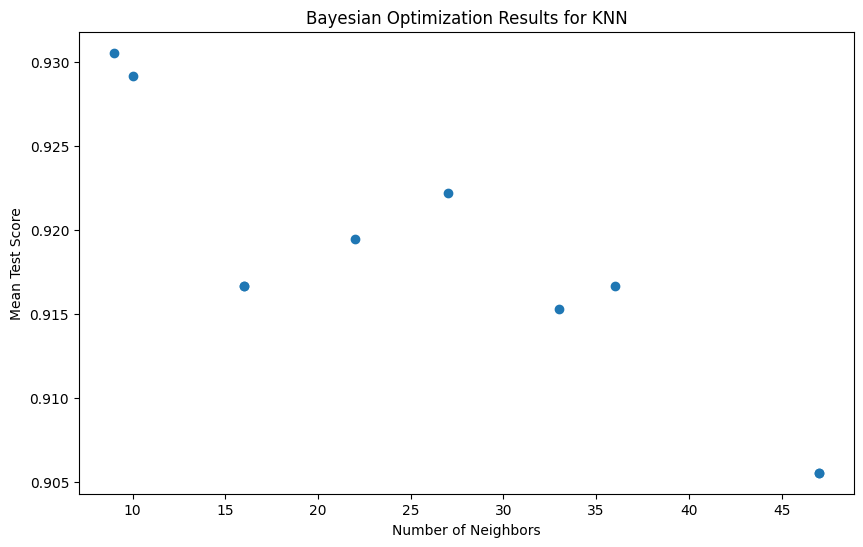

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Integer

# A strangely necessary fix for using BayesSearchCV that others have raised, but has not been addressed yet :/
np.int = int


# Define the KNN model
knn = KNeighborsClassifier()

# Define the hyperparameter search space
search_spaces_knn = {
    'n_neighbors': Integer(1, 50)
}

# Use BayesSearchCV
bayes_search_knn = BayesSearchCV(estimator=knn, search_spaces=search_spaces_knn, n_iter=10, cv=3, verbose=2)
bayes_search_knn_result = bayes_search_knn.fit(X_train, y_train)



# Convert results to DataFrame
df_results_bayes_knn = pd.DataFrame(bayes_search_knn_result.cv_results_)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(df_results_bayes_knn['param_n_neighbors'], df_results_bayes_knn['mean_test_score'])

plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Test Score')
plt.title('Bayesian Optimization Results for KNN')
plt.show()

<a name="p2"></a>

---
## **Part 2: Early Stopping and Regularization**
---

In this section, we explore different regularization techniques. Each regularization technique has its own advantages and use cases, and they can also be combined for even better regularization performance, such as using L1 and L2 regularization together (ElasticNet) or combining dropout with either L1 or L2 regularization in neural networks. Here is an overview of the main types we'll explore:

<br>

**No Regularization**

No additional penalty is added to the loss function.
May lead to overfitting, especially when dealing with complex models or limited training data.

<br>

**L1 Regularization**

Adds a penalty to the loss function proportional to the absolute value of the weights. Encourages sparsity in the weights, leading to some weights being set to exactly zero. Useful for feature selection, as it can effectively prune less important features by setting their corresponding weights to zero. May result in a more interpretable model with fewer parameters.

<br>

**L2 Regularization**

Adds a penalty to the loss function proportional to the square of the weights. Discourages large weights, preventing individual weights from becoming too large and dominating the learning process. Helps to control overfitting by smoothing out the learning landscape and reducing the model's sensitivity to small changes in input features. Does not lead to sparsity in the weights.

<br>


**Dropout**

Randomly sets a fraction of input units to zero during training. Mimics an ensemble of multiple models by dropping out different neurons during each training iteration, effectively preventing co-adaptation of neurons. Helps to prevent overfitting by adding noise to the network and promoting the learning of more robust features.
Does not involve adding any regularization penalty to the loss function.

<br>

**Run the code below to the load the dataset that we will use in this section.**

In [ ]:
# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
data = pd.read_csv(url, names=names)

# Split data into features and target
X = data.drop('class', axis=1)
y = np.array(data['class'])

# Split data into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)


# Convert the numpy arrays to PyTorch tensors with float32 data type
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_valid_torch = torch.tensor(X_valid_scaled, dtype=torch.float32)
y_valid_torch = torch.tensor(y_valid, dtype=torch.float32).unsqueeze(1)

# Create dataset object
train_ds = list(zip(X_train_torch, y_train_torch))
valid_ds = list(zip(X_valid_torch, y_valid_torch))

# Define the DataLoaders
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=True)

dls = DataLoaders(train_dl, valid_dl)

#### **Problem #2.1**

First, let's train a baseline model to compare to, meaning that this does not use any regularization techniques.

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.696477,0.690426,0.538961,00:00
1,0.689413,0.677903,0.649351,00:00
2,0.681969,0.665346,0.662338,00:00
3,0.673761,0.653523,0.655844,00:00
4,0.664970,0.641602,0.649351,00:00
5,0.656354,0.629582,0.642857,00:00
6,0.647430,0.618092,0.649351,00:00
7,0.638118,0.607449,0.649351,00:00
8,0.628353,0.597684,0.649351,00:00
9,0.619236,0.588785,0.649351,00:00


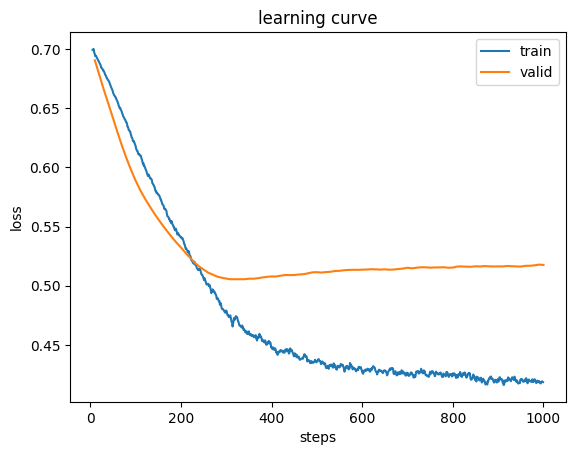

In [ ]:
model = nn.Sequential(
  nn.Linear(8, 12),
  nn.ReLU(),
  nn.Linear(12, 8),
  nn.ReLU(),
  nn.Linear(8, 1),
  nn.Sigmoid()
)

# Training
loss_func = nn.BCELoss()
learn_baseline = Learner(dls, model, loss_func=loss_func, metrics=binary_accuracy)
learn_baseline.fit(100, lr=0.001)


# Plot the training and validation losses
learn_baseline.recorder.plot_loss()
plt.show()

#### **Problem #2.2**

Now, let's explore the use of early stopping.

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.708864,0.701798,0.383117,00:00
1,0.704208,0.693267,0.448052,00:00
2,0.699344,0.684786,0.603896,00:00
3,0.694327,0.676002,0.733766,00:00
4,0.688997,0.666561,0.746753,00:00
5,0.683098,0.656658,0.759740,00:00
6,0.676282,0.646027,0.772727,00:00
7,0.669356,0.634552,0.772727,00:00
8,0.661518,0.622982,0.792208,00:00
9,0.653580,0.610761,0.798701,00:00


No improvement since epoch 23: early stopping


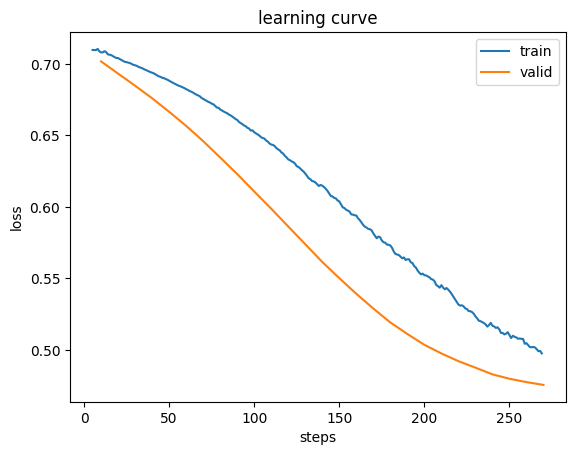

In [ ]:
from fastai.callback.tracker import EarlyStoppingCallback


model = nn.Sequential(
  nn.Linear(8, 12),
  nn.ReLU(),
  nn.Linear(12, 8),
  nn.ReLU(),
  nn.Linear(8, 1),
  nn.Sigmoid()
)

# Training
es_cb = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3)

loss_func = nn.BCELoss()
learn_es = Learner(dls, model, loss_func=loss_func, metrics=binary_accuracy, cbs = [es_cb])
learn_es.fit(100, lr=0.001)


# Plot the training and validation losses
learn_es.recorder.plot_loss()
plt.show()

#### **Problem #2.3**

Here, we use L2 regularization.

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.681871,0.677711,0.642857,00:00
1,0.677421,0.670744,0.642857,00:00
2,0.673732,0.664165,0.642857,00:00
3,0.669693,0.658032,0.642857,00:00
4,0.665905,0.651951,0.642857,00:00
5,0.662004,0.645773,0.642857,00:00
6,0.657623,0.639395,0.642857,00:00
7,0.653332,0.632395,0.649351,00:00
8,0.648426,0.625071,0.649351,00:00
9,0.642787,0.617290,0.649351,00:00


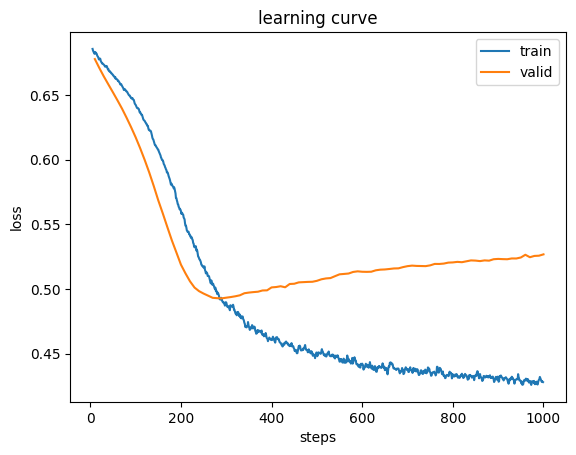

In [ ]:
model = nn.Sequential(
  nn.Linear(8, 12),
  nn.ReLU(),
  nn.Linear(12, 8),
  nn.ReLU(),
  nn.Linear(8, 1),
  nn.Sigmoid()
)

# Training
loss_func = nn.BCELoss()
learn_l2 = Learner(dls, model, loss_func=loss_func, metrics=binary_accuracy, wd = 1e-6)
learn_l2.fit(100, lr=0.001)


# Plot the training and validation losses
learn_l2.recorder.plot_loss()
plt.show()

#### **Problem #2.4**

Lastly, we look at the results of using a dropout regularization layer.

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.659133,0.663269,0.642857,00:00
1,0.656874,0.658814,0.642857,00:00
2,0.653983,0.654350,0.642857,00:00
3,0.650366,0.649439,0.642857,00:00
4,0.648120,0.643810,0.642857,00:00
5,0.645122,0.637820,0.642857,00:00
6,0.640763,0.631424,0.642857,00:00
7,0.635251,0.624136,0.642857,00:00
8,0.629631,0.616415,0.642857,00:00
9,0.623525,0.608469,0.642857,00:00


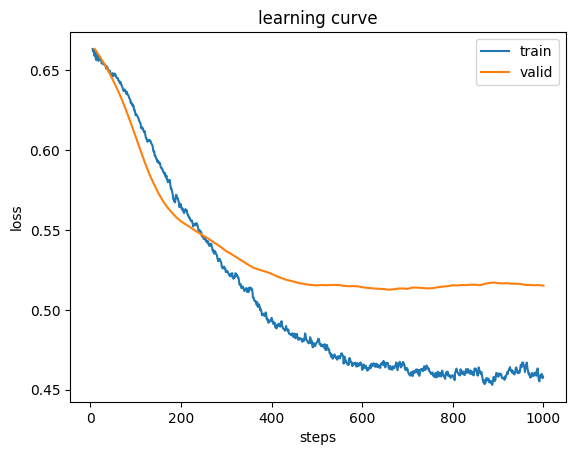

In [ ]:
model = nn.Sequential(
  nn.Linear(8, 12),
  nn.ReLU(),
  nn.Dropout(p=0.4),
  nn.Linear(12, 8),
  nn.ReLU(),
  nn.Linear(8, 1),
  nn.Sigmoid()
)

# Training
loss_func = nn.BCELoss()
learn_drop = Learner(dls, model, loss_func=loss_func, metrics=binary_accuracy)
learn_drop.fit(100, lr=0.001)


# Plot the training and validation losses
learn_drop.recorder.plot_loss()
plt.show()

#### **Problem #2.5**

It's easiest to compare the models by looking at their learning curves all together.

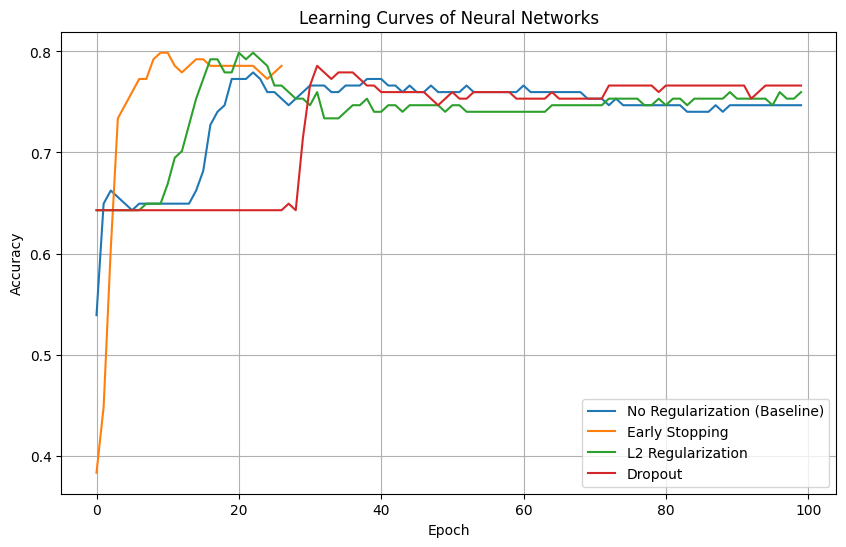

In [ ]:
metric_idx = 2
baseline_accuracy = [values[metric_idx] for values in learn_baseline.recorder.values]
es_accuracy = [values[metric_idx] for values in learn_es.recorder.values]
l2_accuracy = [values[metric_idx] for values in learn_l2.recorder.values]
drop_accuracy = [values[metric_idx] for values in learn_drop.recorder.values]


# Plot learning curves for all neural networks
plt.figure(figsize=(10, 6))

plt.plot(baseline_accuracy, label='No Regularization (Baseline)')
plt.plot(es_accuracy, label='Early Stopping')
plt.plot(l2_accuracy, label='L2 Regularization')
plt.plot(drop_accuracy, label='Dropout')


# Plot labels and legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curves of Neural Networks')
plt.legend()
plt.grid(True)
plt.show()

#### **Problem #2.6**

Complete the code below to apply all three approaches at the same time.

In [ ]:
# COMPLETE THIS CODE

##### **Solution**

epoch,train_loss,valid_loss,binary_accuracy,time
0,0.766923,0.756251,0.370130,00:00
1,0.761180,0.743413,0.370130,00:00
2,0.751923,0.731368,0.357143,00:00
3,0.744847,0.720467,0.363636,00:00
4,0.736179,0.709771,0.396104,00:00
5,0.728036,0.699435,0.448052,00:00
6,0.719271,0.689024,0.519481,00:00
7,0.710422,0.679311,0.577922,00:00
8,0.701876,0.669118,0.597403,00:00
9,0.693307,0.658782,0.655844,00:00


No improvement since epoch 27: early stopping


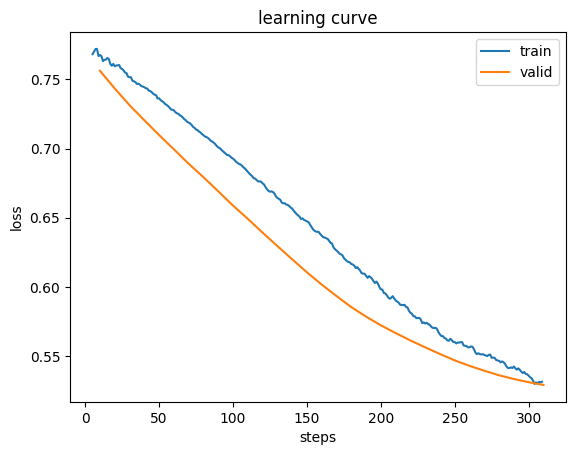

In [ ]:
model = nn.Sequential(
  nn.Linear(8, 12),
  nn.ReLU(),
  nn.Dropout(p=0.4),
  nn.Linear(12, 8),
  nn.ReLU(),
  nn.Linear(8, 1),
  nn.Sigmoid()
)


# Training
es_cb = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3)

loss_func = nn.BCELoss()
learn_all = Learner(dls, model, loss_func=loss_func, metrics=binary_accuracy, cbs = [es_cb], wd = 1e-6)
learn_all.fit(100, lr=0.001)


# Plot the training and validation losses
learn_all.recorder.plot_loss()
plt.show()

<a name="p3"></a>

---
## **Part 3: Challenge Problem**
---

In this section, it's up to you to apply what you've learned above to accomplish the following open ended challenge: build and compare different machine learning models for classifying fashion items from images using the MNIST dataset. You will explore neural network models with various regularization techniques, early stopping, L2 regularization, and dropout. Your goal is to determine which model performs best in terms of accuracy. Additionally, you will perform hyperparameter tuning using random search or Bayesian optimization to find the best hyperparameters for your models.

<br>

**NOTES**:
* The data is images of handwritten digits that are to be classified. However, they have been turned from a 28x28 grid (matrix) of pixels into a single 784 long column (vector) of pixel values.
* Testing all possible models is simply not feasible! It will take far too long without more advanced equipment and approaches like multiprocessing. Focus on just a few techniques and models here to keep your total training time within a reasonable limit (**15 - 20 minutes** should be enough time to perform about 5 searches. It took about 23 minutes for us to acheive a nearly 0.977 accuracy, which is considered pretty strong performance on the MNIST dataset.
* To search for a good value of dropoout, you can use `hp.uniform('name', 0, 1)` to search for values between 0 and 1.

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 34966574.16it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1099614.15it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9675390.04it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3670622.11it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



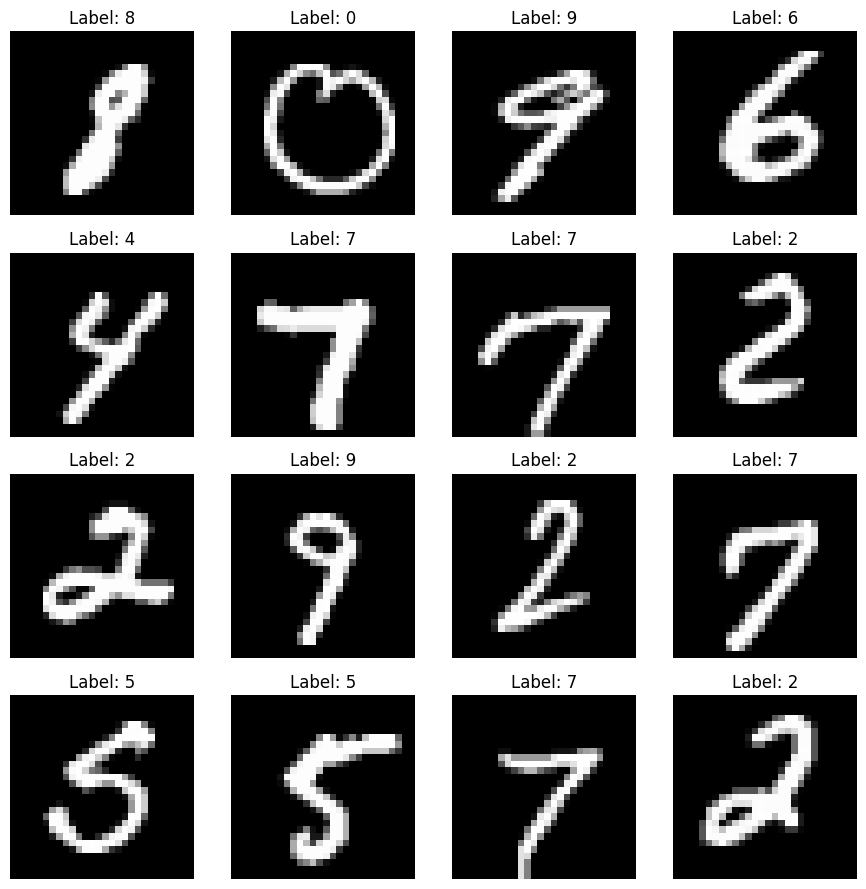

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from torchvision.datasets import MNIST

from hyperopt import hp, tpe, fmin, STATUS_OK, Trials
import time


# Define the transformations
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
train_dataset = MNIST(root='./data',
                      train=True,
                      download=True,
                      transform=transform)
valid_dataset = MNIST(root='./data',
                      train=False,
                      download=True,
                      transform=transform)

# Create the DataLoaders object
train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size=64, shuffle=True)
dls = DataLoaders(train_dl, valid_dl)

# Set the number of images per row and column in the grid
n_row = 4
n_col = 4

# Get a batch of training data
images, labels = next(iter(train_dl))

# Create a grid of images and labels
fig, axs = plt.subplots(n_row, n_col, figsize=(9, 9))
for i in range(n_row):
    for j in range(n_col):
        ax = axs[i, j]
        img_idx = i * n_col + j
        img = images[img_idx].reshape(28, 28).numpy()  # Reshape the image to 28x28
        label = labels[img_idx].item()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Label: {label}")
        ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# COMPLETE THIS CODE

##### **Solution**

In [ ]:
# Define the objective function to minimize (Hyperopt minimizes the loss, so we negate accuracy)
def objective(params):

    model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28 * 28, params['neurons']),
      nn.ReLU(),
      nn.Dropout(p=params['drop']),
      nn.Linear(params['neurons'], 10),
      nn.Softmax()
    )

    es_cb = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3)

    loss_func = nn.CrossEntropyLoss()
    learn = Learner(dls, model, loss_func=loss_func, metrics=accuracy, cbs = [es_cb], wd = params['l2'])
    learn.fit(10, lr=params['learning_rate'])

    valid_loss, valid_accuracy = learn.validate()

    return {'loss': -valid_accuracy, 'status': STATUS_OK}



# Define the search space
space = {
    'neurons': hp.randint('neurons', 64, 1024),
    'drop': hp.uniform('drop', 0, 1),
    'l2': hp.loguniform('l2', np.log(1e-6), np.log(1e-3)),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2))
}

# Perform optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=5)
print(best)

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,accuracy,time
0,1.584607,1.552629,0.921100,00:35
1,1.563808,1.533939,0.934400,00:34
2,1.542994,1.522052,0.944700,00:35
3,1.536268,1.514614,0.951300,00:35
4,1.527939,1.509553,0.955500,00:33
5,1.523329,1.505963,0.958100,00:35
6,1.520619,1.503421,0.959700,00:35
7,1.517410,1.501487,0.962100,00:35


No improvement since epoch 4: early stopping
  0%|          | 0/5 [04:40<?, ?trial/s, best loss=?]

 20%|██        | 1/5 [04:44<18:56, 284.23s/trial, best loss: -0.9621000289916992]

epoch,train_loss,valid_loss,accuracy,time
0,1.570794,1.534799,0.926500,00:35
1,1.588020,1.527237,0.933800,00:37
2,1.569880,1.535651,0.925800,00:37
3,1.564007,1.524998,0.936200,00:37


No improvement since epoch 0: early stopping
 20%|██        | 1/5 [07:12<18:56, 284.23s/trial, best loss: -0.9621000289916992]

 40%|████      | 2/5 [07:17<10:20, 206.96s/trial, best loss: -0.9621000289916992]

epoch,train_loss,valid_loss,accuracy,time
0,1.908469,1.778328,0.775800,00:31
1,1.820999,1.685431,0.823200,00:32
2,1.775690,1.637002,0.865600,00:30
3,1.744446,1.608054,0.887100,00:33
4,1.729188,1.593752,0.893600,00:33
5,1.715943,1.584861,0.898500,00:32
6,1.712701,1.578722,0.900400,00:31
7,1.693748,1.573608,0.902300,00:30
8,1.689536,1.569517,0.904000,00:30
9,1.680737,1.566215,0.905700,00:33


 60%|██████    | 3/5 [12:39<08:39, 259.86s/trial, best loss: -0.9621000289916992]

epoch,train_loss,valid_loss,accuracy,time
0,1.667734,1.563255,0.897400,00:40
1,1.663495,1.556853,0.903800,00:43
2,1.648857,1.553592,0.907400,00:43
3,1.640721,1.550645,0.910200,00:45
4,1.634518,1.550580,0.910300,00:45
5,1.632987,1.549055,0.911800,00:46
6,1.629413,1.549679,0.911000,00:48


No improvement since epoch 3: early stopping
 60%|██████    | 3/5 [17:53<08:39, 259.86s/trial, best loss: -0.9621000289916992]

 80%|████████  | 4/5 [17:57<04:42, 282.68s/trial, best loss: -0.9621000289916992]

epoch,train_loss,valid_loss,accuracy,time
0,1.536886,1.531502,0.935800,00:41
1,1.506785,1.507699,0.959000,00:40
2,1.503905,1.499598,0.965400,00:41
3,1.490343,1.492688,0.972300,00:42
4,1.489363,1.490633,0.973000,00:41
5,1.484851,1.487703,0.975400,00:41
6,1.479558,1.486092,0.976900,00:41


No improvement since epoch 3: early stopping
 80%|████████  | 4/5 [22:47<04:42, 282.68s/trial, best loss: -0.9621000289916992]

100%|██████████| 5/5 [22:52<00:00, 274.46s/trial, best loss: -0.9768999814987183]
Best Parameters: {'drop': 0.16051538534658194, 'l2': 7.519488634551834e-06, 'learning_rate': 0.0002283450759211517, 'neurons': 932}
Best Score: 0.9768999814987183


#End of notebook
---
© 2024 The Coding School, All rights reserved